In [79]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
import pandas as pd
import statistics as stat

# Efficient Frontier and Optimal Complete Portfolio
How do we get this fancy graph?

1. **Opportunity Set:** Suppose we have two assets, A and B, both with its own risk (measured in standard deviation, denoted as $\sigma$) and expected return. The correlation between them is $\rho$. Now if we vary the our holdings of A and B between $0\%$ to $100\%$ and plot the resultant expected return and risk, we get the opportunity set. The upper half of the opportunity set is called the efficient frontier;

2. **Capital Market Line (CML)**: CML is a special case of capital allocation line (CAL)--the line which makes up the allocation between a risk-free asset and a risky portfolio for an investor. In the case of CML, its risky portfolio is the so-called optimal portfolio of risky assets, also known as the market portfolio. The market portfolio is considered "optimal" because it has the largest Sharpe ratio among all possible portfolios;

3. **Indifference Curve**: IC is a curve on which all points have the exactly same utility score calculated from the utility function.

4. The conclusion of the graph follows the above three steps: we first find the opportunity set (as well as the efficient frontier); then we find the capital market line (as well as the tangent portfolio); after that, we find the optimal complete portfolio which is the point where the indifference curve and the CML touch.

## Formulas and Notes:
1. The formula for population variance ($\sigma^2$) and standard deviation ($\sigma$) is $$\sigma^2 = \frac{\Sigma(x_i - \mu)^2}{N}$$ and the formula for sample variance ($S^2$) and standard deviation ($S$) is $$S^2 = \frac{\Sigma(x_i - \bar{x})^2}{n-1}$$
  Note the "minor" differences between the two formulas:
      1. Symbols used are different (e.g. $\sigma$, $S$, $\mu$, etc);
      2. Denominators are different ($N$ vs $n-1$): the use of $n-1$ instead of $N$ is called Bessel's correction. Why is it so? We can understand it from the aspect of degrees of freedom. The idea is that for $n$ observations, we have $n$ residuals, i.e., $x_1 - \bar{x}$, $x_2 - \bar{x}$, $x_3 - \bar{x}$, ..., $x_n - \bar{x}$. For these $n$ residuals, There are only $n − 1$ independent residuals, that is, we can only vary $n-1$ residuals freely (since the $n-th$ residual is fixed as the sum of all residuals has to be $0$).
      3. Intuitively, we may understand the Bessel's correction from an extreme case when $n = 1$, under which $x_1$ is equal to $\bar{x}$. We cannot get any meaningful estimate since if we plug in $x_1$ and $\bar{x}$ into the population formula, $\sigma^2$ will always be $0$. The use of $n-1$ can also be seen as a input validation used to forbid people from plugging in the incorrect data into the formula to get a wrong result. (It also explains why the denominator can only be $n-1$ instead of $n-2$);


2. The formula for (population) covariance is basically a variant of the formula for variance: $$cov(x, y) = \frac{\Sigma(x_i - \bar{x})(y_i - \bar{y})}{N}$$


3. The formula for correlation (i.e., Pearson's correlation coefficient) is $$\rho_{xy} = \frac{\Sigma(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\Sigma(x_i - \bar{x})^2\Sigma(y_i - \bar{y})^2}}$$ which can also be written as $$\rho_{xy} = \frac{cov(x, y)}{\sigma_x \sigma_y}$$ Note that we use $\rho$ when the value is calculated from the population and we use $r$ if the value is estimated from a sample;


4. The formula for Sharpe ratio $S(x)$ of a portfolio $p$ is: $$ S(x) = \frac{(R_p - R_f)}{\sqrt{var(R_p - R_f)}} $$ where $R_p$ is the return of the portfolio $p$ and $R_f$ is the return of a risk-free asset. It is even more commonly written in this form: $$ S(x) = \frac{(r_p - R_f)}{\sigma_p} $$ where $\sigma_p$ is defined as portfolio $p$'s risk of **excess return**, instead of $p$'s risk of its return. Note that we can actually extend the definition of Sharpe ratio and benchmark our portfolio against another risky asset instead of a risk-free asset. In this scenario, we have to use first formula to calculate the risk of $p$'s **excess return** relative to a risky benchmark;

5. The formula for utility score is $$U = E[r_p] - \frac{1}{2}\sigma_p^2A$$ where $E[r_p]$ is the expected return of portfolio $p$, $\sigma_p^2$ is the variance of $p$ and $A$ is a risk-aversion coefficient. Most online material does not specify how we arrive at the coefficient $\frac{1}{2}$. One not-so-authoritative [webpage](https://thismatter.com/money/investments/modern-portfolio-theory.htm) does say it is a "normalizing factor to reduce the size of the variance". Perhaps it is just a more or less arbitrarily selected coefficient...


6. It is important to be aware that MPT, CAPM, etc are all normative models instead of positive models, that is, they only reflect some experts' belief in how the market *ought to* work, rather than how the market *actually* works.

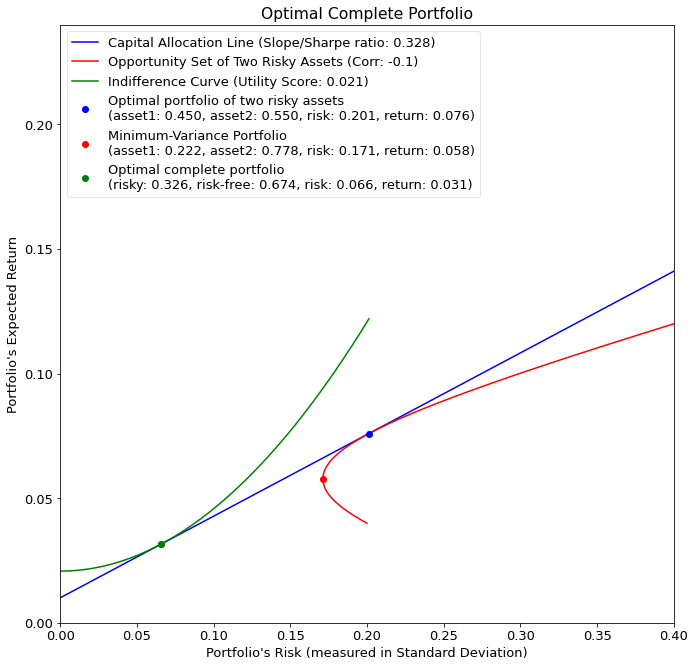

In [80]:
plot_optimal_complete_portfolio(expected_returns=[0.12, 0.04], sigmas=[0.4, 0.2], rho=-0.1,
                                rf=0.01, risk_aversion_coefficient=5)

In [81]:
def init_plot(x_upper: int, y_upper: int):
    plt.figure(figsize = (11, 11))
    plt.rcParams.update({'font.size': 13})
    plt.xlim(0, x_upper)
    plt.ylim(0, y_upper)
    plt.title('Optimal Complete Portfolio')
    plt.xlabel("Portfolio's Risk (measured in Standard Deviation)")
    plt.ylabel("Portfolio's Expected Return")
    

def plot_optimal_complete_portfolio(expected_returns: List[float], sigmas: List[float], rho: float, 
                                    rf: float, risk_aversion_coefficient: float):

    # Abbreviations and definitions:
    # er: expected return
    # mv: minimum variance
    # port_p: the risky portfolio consisting of two risky assets
    # port_c: the complete portfolio consisting of a risky portfolio (i.e., port_p) and a risk-free asset.
    # rf: return of a risk-free asset
    # sr: Sharpe 
    #
    # Notes:
    # 1. Correlation and covariance are related but different concepts. 𝜌(rho) is the greek alphabet
    #    used to represent correlation.
    # 2. The definitions of port_p and port_c are the same as those on Prof. Benz's slides.
    
    assert len(expected_returns) == 2
    assert len(sigmas) == 2
    assert rf < 0.1

    A = risk_aversion_coefficient
    granularity = 10_000
    # If you just want to plot the graph, a very low granularity (e.g., 50) will suffice;
    # If you want the numbers to be accurate enough, you need to specify a much higher granularity.
    port_p_σs = []
    port_p_sr = -1
    port_p_returns = []
    port_p_w1 = 0
    port_p_σ = 0
    port_p_return = 0

    port_mv_w1 = 0
    port_mv_return = 0
    port_mv_σ = 6666

    for i in range(granularity + 1):
        w1 = i / granularity
        w2 = 1 - w1
        σ = get_portfolio_sigma(weights_based_on_market_price = [w1, w2], sigmas = sigmas, rho = rho)
        port_p_σs.append(σ)
        port_p_returns.append(w1 * expected_returns[0] + w2 * expected_returns[1])
        if σ!= 0:
            sr = (port_p_returns[i] - rf) / σ
        else: # if two assets are perfectly negatively correlated, var and σ will become zero.
            sr = 2147483647
            
        if sr > port_p_sr:
            # Here we find the tangent portfolio
            port_p_sr = sr
            port_p_w1 = w1
            port_p_σ = σ
            port_p_return = port_p_returns[i]
        if σ < port_mv_σ:
            # Here we find the minimum variance portfolio
            port_mv_σ = σ
            port_mv_return = port_p_returns[i]
            port_mv_w1 = w1

    port_c_returns = []
    port_c_σs = []
    for i in range(granularity + 1):

        port_c_return, port_c_σ = get_return_and_risk_of_portfolio_on_cal(
                 weight_risky = (i / granularity),
                 weight_risk_free = 1 - (i / granularity),
                 risk_free_return = rf,
                 expected_return_of_risky_assets = port_p_return,
                 standard_deviation_aka_risk_of_risky_assets = port_p_σ)
        port_c_returns.append(port_c_return)
        port_c_σs.append(port_c_σ)

    utils = get_utility_score(expected_returns = port_c_returns,
                              risk_aversion_coefficients = [A] * len(port_c_returns),
                              standard_deviations_aka_risks = port_c_σs)
    max_util = max(utils)
    returns_from_max_util = []
    for i in range(granularity + 1):
        returns_from_max_util.append(max_util + 0.5 * A * port_c_σs[i] ** 2)

    x = np.array(port_c_σs)
    f = np.array(port_c_returns)
    g = np.array(returns_from_max_util)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()

    y_upper = max(expected_returns[0], expected_returns[1]) * 2    
    init_plot(x_upper=max(port_p_σs), y_upper=y_upper)

    # ===== Plot three curves =====
    plt.plot([0, max(port_p_σs)], [rf, max(port_p_σs) * (port_p_sr) + rf], color='b',
             label=f'Capital Allocation Line (Slope/Sharpe ratio: {port_p_sr:.3f})')
    plt.plot(port_p_σs, port_p_returns, color='r',
             label=f'Opportunity Set of Two Risky Assets (Corr: {rho})')
    plt.plot(port_c_σs, returns_from_max_util, color='g',
             label=f'Indifference Curve (Utility Score: {max_util:.3f})')

    # ===== Plot three points (i.e., portfolios) =====
    plt.plot(port_p_σ, port_p_return, 'bo',
             label='Optimal portfolio of two risky assets\n'
                   f'(asset1: {port_p_w1:.3f}, asset2: {1 - port_p_w1:.3f}, '
                   f'risk: {port_p_σ:.3f}, return: {port_p_return:.3f})')
    plt.plot(port_mv_σ, port_mv_return, 'ro',
             label='Minimum-Variance Portfolio\n'
                   f'(asset1: {port_mv_w1:.3f}, asset2: {1 - port_mv_w1:.3f}, '
                   f'risk: {port_mv_σ:.3f}, return: {port_mv_return:.3f})')
    plt.plot(x[idx], f[idx], 'go',
             label='Optimal complete portfolio\n'
                   f'(risky: {x[idx][0] / port_p_σ:.3f}, '
                   f'risk-free: {1 - x[idx][0] / port_p_σ:.3f}, '
                   f'risk: {x[idx][0]:.3f}, return: {f[idx][0]:.3f})')    

    plt.legend(loc = 'upper left', framealpha=0.5)
    plt.show()

# Opportunity Set

1. As mentioned in the above section, an opportunity set consists of all the possible (well excluding the use leverage) combination of two (usually risky) assets.

2. According to the basic assumption of the Modern Portfolio Theory, unless the entire market is irrational, it is impossible that a riskier asset has lower returns relative to a less risky asset. This assumption is NOT enforced in the function. You can try inputting such combinations just for fun!

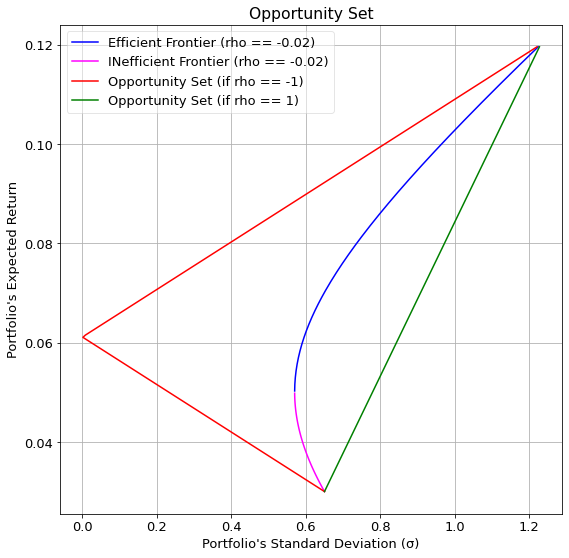

In [82]:
plot_opportunity_set(expected_returns=[0.12, 0.03], sigmas=[1.23, 0.65], rho=-0.02)

In [83]:
def plot_opportunity_set(expected_returns: List[float], sigmas: List[float], rho: float):

    assert len(expected_returns) == 2 and len(sigmas) == 2
    assert rho <= 1 and rho >= -1
    
    granularity = 200
    σ, σ_neg, σ_pos = [], [], []
    portfolio_return = []
    for i in range(0, granularity):
        weights = [i / granularity, 1 - i / granularity]
        σ.append(get_portfolio_sigma(weights_based_on_market_price=weights, sigmas=sigmas, rho=rho))
        σ_neg.append(get_portfolio_sigma(weights_based_on_market_price=weights, sigmas=sigmas, rho=-1))
        σ_pos.append(get_portfolio_sigma(weights_based_on_market_price=weights, sigmas=sigmas, rho=1))
        portfolio_return.append(weights[0] * expected_returns[0] + weights[1] * expected_returns[1])

    cutoff = σ.index(min(σ))

    plt.figure(figsize = (9, 9))
    plt.title('Opportunity Set')
    plt.xlabel("Portfolio's Standard Deviation (σ)")
    plt.ylabel("Portfolio's Expected Return")
    plt.grid() # it turns out that this graph looks better with a grid...
    plt.plot(σ[cutoff:], portfolio_return[cutoff:], color='blue',
             label=f'Efficient Frontier (rho == {rho})')
    plt.plot(σ[0:cutoff], portfolio_return[0:cutoff], color='magenta',
             label=f'INefficient Frontier (rho == {rho})')
    plt.plot(σ_neg, portfolio_return, color='red', label='Opportunity Set (if rho == -1)')
    plt.plot(σ_pos, portfolio_return, color='green', label='Opportunity Set (if rho == 1)')
    plt.legend(loc = 'best', framealpha = 0.5)
    plt.show()

# Utility Function and Optimal Allocation

In [84]:
def lec2_plot_cal_utility_function_and_get_optimal_allocation(
                        risk_free_return: float,
                        expected_return_of_risky_assets: float,
                        variance: float,
                        standard_deviation_aka_risk_of_risky_assets: float,
                        risk_aversion_coefficient: float):

    assert variance is None or standard_deviation_aka_risk_of_risky_assets is None
    A = risk_aversion_coefficient
    if standard_deviation_aka_risk_of_risky_assets is None:
        standard_deviation_aka_risk_of_risky_assets = variance ** 0.5

    portfolio_expected_returns = []
    portfolio_std_dev_aka_risks = []
    returns_for_highest_utility = []
    returns_for_highest_utility_50percent = []
    returns_for_highest_utility_150percent = []

    upper_bound = 200000

    for i in range(upper_bound):

        portfolio_expected_return, portfolio_σ_aka_risk = get_return_and_risk_of_portfolio_on_cal(
                 weight_risky = (i / (upper_bound / 2)),
                 weight_risk_free = 1 - (i / (upper_bound / 2)),
                 risk_free_return = risk_free_return,
                 expected_return_of_risky_assets = expected_return_of_risky_assets,
                 standard_deviation_aka_risk_of_risky_assets = standard_deviation_aka_risk_of_risky_assets)
        portfolio_expected_returns.append(portfolio_expected_return)
        portfolio_std_dev_aka_risks.append(portfolio_σ_aka_risk)

    utility_scores = get_utility_score(
           expected_returns = portfolio_expected_returns,
           risk_aversion_coefficients = [A] * len(portfolio_expected_returns),
           standard_deviations_aka_risks = portfolio_std_dev_aka_risks)


    max_util = max(utility_scores)
    util_50percent = max_util * 0.5
    util_150percent = max_util * 1.5

    for i in range(upper_bound):
        returns_for_highest_utility.append(max_util + 0.5 * A * portfolio_std_dev_aka_risks[i] ** 2)
        returns_for_highest_utility_50percent.append(util_50percent + 0.5 * A * portfolio_std_dev_aka_risks[i] ** 2)
        returns_for_highest_utility_150percent.append(util_150percent + 0.5 * A * portfolio_std_dev_aka_risks[i] ** 2)



    optimal_allocation_in_risk_assets = (expected_return_of_risky_assets - risk_free_return) / (A * standard_deviation_aka_risk_of_risky_assets ** 2)

    _lec2_plotting_cal_and_indifference_curve(
            upper_bound = upper_bound,
            portfolio_std_dev_aka_risks = portfolio_std_dev_aka_risks,
            portfolio_expected_returns = portfolio_expected_returns,
            returns_for_highest_utility = returns_for_highest_utility,
            returns_for_highest_utility_50percent = returns_for_highest_utility_50percent,
            returns_for_highest_utility_150percent = returns_for_highest_utility_150percent,
            max_util = max_util,
            A = A,
            utility_scores = utility_scores,
            util_50percent = util_50percent,
            util_150percent = util_150percent)

    return utility_scores, optimal_allocation_in_risk_assets

In [85]:
def _lec2_plotting_cal_and_indifference_curve(
        upper_bound,
        portfolio_std_dev_aka_risks,
        portfolio_expected_returns,
        returns_for_highest_utility,
        returns_for_highest_utility_50percent,
        returns_for_highest_utility_150percent,
        max_util,
        A,
        utility_scores,
        util_50percent,
        util_150percent):

    # Definitions of c is the same as the lecture slides using by Prof. Benz
    port_c_σ = portfolio_std_dev_aka_risks
    port_c_ret = portfolio_expected_returns
    fig = plt.figure(figsize = (4 * 4, 4 * 3))

    fig.add_subplot(2, 2, 1)
    plt.title('Capital Allocation Line and Indifference Curve')
    plt.xlabel('Portfolio\'s Standard Deviation (aka Risk)')
    plt.ylabel('Portfolio\'s Return')
    plt.xlim(0, max(port_c_σ))
    plt.ylim(0, max(port_c_σ))
    plt.grid()

    plt.plot(port_c_σ, returns_for_highest_utility, color = 'b', label = 'IC (Utility Score: {:.4f})'.format(max_util))
    plt.plot(port_c_σ, port_c_ret, color = 'r',
             label = 'CAL (risky + risk-free assets)\n (Sharpe Ratio (i.e. slope): {:.4f})'.format((port_c_ret[int(upper_bound / 2)] - port_c_ret[0]) / port_c_σ[int(upper_bound / 2)]))

    plt.plot(port_c_σ[int(upper_bound / 2)], port_c_ret[int(upper_bound / 2)],'ro',
            label = '100% to risky assets\nRisk Aversion Coefficient (aka A): {}'.format(A))

    x = np.array(port_c_σ)
    f = np.array(port_c_ret)
    g = np.array(returns_for_highest_utility)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    plt.plot(x[idx], f[idx], 'bo', label = 'Optimal Portfolio\n(risky: {:.4f} + risk-free: {:.4f})'.format(port_c_σ.index(x[idx][0])*2/upper_bound, 1 - port_c_σ.index(x[idx][0])*2/upper_bound))
    plt.annotate('(Risk: {:.4f}, Return: {:.4f})'.format(x[idx][0], f[idx][0]),
                 xy=(x[idx][0], f[idx][0]), xytext=(x[idx][0] * 1.3, f[idx][0] * 0.7),
                 arrowprops=dict(facecolor='black', arrowstyle ='-|>'))
    plt.legend(loc = 'upper left', framealpha = 0.5)

    fig.add_subplot(2, 2, 2)
    plt.title('Utility Function')
    plt.xlabel('Allocation in Risky Assets (%)')
    plt.ylabel('Utility')
    plt.grid()
    upper_bound_x = [x / (upper_bound/100) for x in range(upper_bound)]
    plt.plot((upper_bound_x), utility_scores, color = 'r', linewidth = 1)

    fig.add_subplot(2, 2, 3)
    plt.title('CAL and IC (Wrong Example)')
    plt.xlabel('Portfolio Standard Deviation (aka Risk)')
    plt.ylabel('Portfolio Return')
    plt.grid()
#    plt.plot(portfolio_std_dev_aka_risks, returns_for_highest_utility, color = 'r', linewidth = 1)
    plt.plot(port_c_σ, port_c_ret, color = 'r', linewidth = 1, label = 'CAL')
    plt.plot(port_c_σ,
             returns_for_highest_utility_50percent,
             color = 'y', linewidth = 1, label = 'IC (Utility Score == {})'.format(round(util_50percent, 3)))
    plt.plot(port_c_σ,
             returns_for_highest_utility,
             color = 'b', linewidth = 1, label = 'IC (Utility Score == {})'.format(round(max_util, 3)))
    plt.plot(port_c_σ,
             returns_for_highest_utility_150percent,
             color = 'g', linewidth = 1, label = 'IC (Utility Score == {})'.format(round(util_150percent, 3)))

    x = np.array(port_c_σ)
    f = np.array(port_c_ret)
    g = np.array(returns_for_highest_utility_50percent)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    plt.plot(x[idx], f[idx], 'yo')

    x = np.array(port_c_σ)
    f = np.array(port_c_ret)
    g = np.array(returns_for_highest_utility)
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    plt.plot(x[idx], f[idx], 'bo')

    plt.annotate("Blue and yellow points have the same\nsharpe ratio but different utility scores!",
                 xy=(x[idx][0], f[idx][0]),
                 xytext=(x[idx][0] * 1.3, f[idx][0] * 0.7),
                 arrowprops=dict(facecolor='black', arrowstyle ='-|>'))
    plt.annotate(' No allocation can achieve\nthis utility score!',
                 xy=(port_c_σ[int(upper_bound / 2)], returns_for_highest_utility_150percent[int(upper_bound / 2)]),
                 xytext=(port_c_σ[int(upper_bound / 2)] * 0.6, returns_for_highest_utility_150percent[int(upper_bound / 2)] * 1.3),
                 arrowprops=dict(facecolor='black', arrowstyle ='-|>'))
    plt.legend(loc = 'best', framealpha = 0.5)
    plt.show()

# Common Methods

In [86]:
def get_utility_score(expected_returns: List[float],
                           risk_aversion_coefficients: List[float],
                           standard_deviations_aka_risks: List[float]) -> List[float]:

    assert len(expected_returns) == len(risk_aversion_coefficients)

    σ_squared = []
    for i in range(len(standard_deviations_aka_risks)):
        σ_squared.append(standard_deviations_aka_risks[i] ** 2)

    utility_scores = [0] * len(expected_returns)

    for i in range(len(utility_scores)):
        utility_scores[i] = expected_returns[i] - 0.5 * risk_aversion_coefficients[i] * σ_squared[i]
      #  print(i, utility_scores[i], expected_returns[i], risk_aversion_coefficients[i], σ_squared[i])
    return utility_scores


def get_portfolio_sigma(weights_based_on_market_price: List[float],
                        sigmas: List[float], rho: float) -> float:

    assert len(weights_based_on_market_price) == 2
    assert len(sigmas) == 2
    assert sum(weights_based_on_market_price) == 1

    σs = sigmas
    w = weights_based_on_market_price
    
    portfolio_var = w[0] ** 2 * σs[0] ** 2 + w[1] ** 2 * σs[1] ** 2 + 2 * w[0] * w[1] * σs[0] * σs[1] * rho
    
   # print(portfolio_var, w[0] ** 2 * σs[0] ** 2, w[1] ** 2 * σs[1] ** 2)
    portfolio_σ = portfolio_var ** 0.5
    return portfolio_σ

# cal: capital allocation line
def get_return_and_risk_of_portfolio_on_cal(
                                    weight_risky: float,
                                    weight_risk_free: float,
                                    risk_free_return: float,
                                    expected_return_of_risky_assets: float,
                                    standard_deviation_aka_risk_of_risky_assets: float,
                                    variances_aka_standard_deviations_squared = None):

    assert 1 - (weight_risky + weight_risk_free) < 10 ** -10
    assert risk_free_return < 0.1 and expected_return_of_risky_assets < 0.5
    assert risk_free_return < expected_return_of_risky_assets
    assert variances_aka_standard_deviations_squared == None or standard_deviation_aka_risk_of_risky_assets == None
    assert variances_aka_standard_deviations_squared != None or standard_deviation_aka_risk_of_risky_assets != None
    
    σ_squared = variances_aka_standard_deviations_squared
    σ = standard_deviation_aka_risk_of_risky_assets
    if σ == None:
        σ = σ_squared ** 0.5

    portfolio_expected_return = (1 - weight_risky) * risk_free_return
    portfolio_expected_return += weight_risky * expected_return_of_risky_assets

    
    portfolio_std_dev_aka_risk = weight_risky * σ

    return portfolio_expected_return, portfolio_std_dev_aka_risk

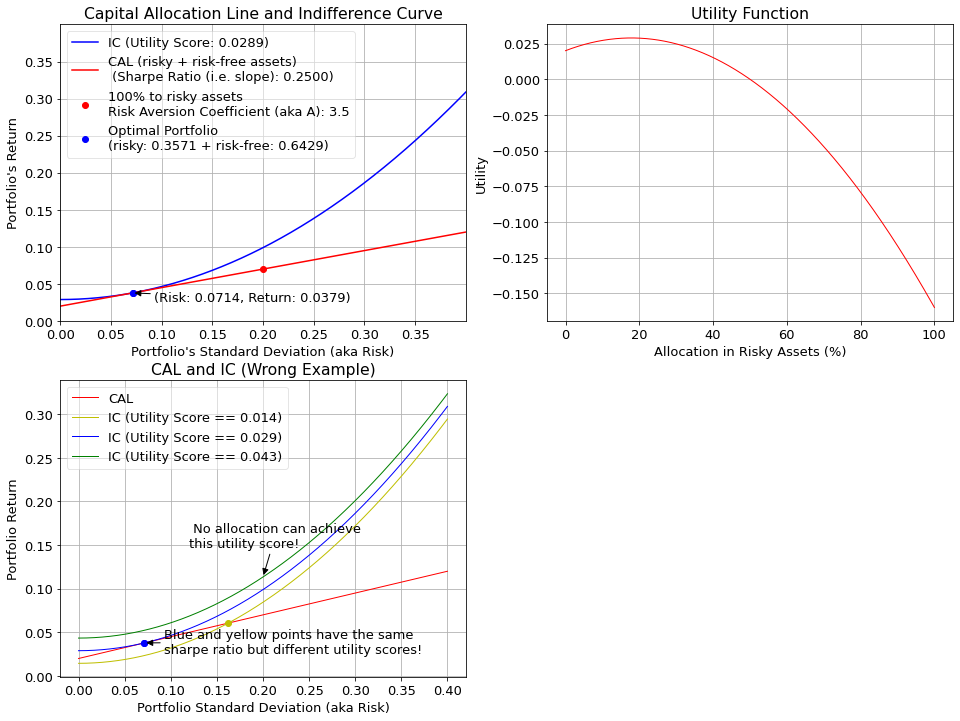

([0.02,
  0.020000499993,
  0.020000999971999996,
  0.020001499937,
  0.020001999888,
  0.020002499825,
  0.020002999748,
  0.020003499657,
  0.020003999552,
  0.020004499433000002,
  0.020004999300000003,
  0.020005499152999998,
  0.020005998992,
  0.020006498817000003,
  0.020006998628,
  0.020007498425000003,
  0.020007998207999998,
  0.020008497977,
  0.020008997732000003,
  0.020009497472999998,
  0.0200099972,
  0.020010496913,
  0.020010996612,
  0.020011496297,
  0.020011995968,
  0.020012495625,
  0.020012995268,
  0.020013494897,
  0.020013994512000005,
  0.020014494113000002,
  0.0200149937,
  0.020015493273,
  0.020015992832,
  0.020016492377,
  0.020016991908,
  0.020017491425,
  0.020017990928000003,
  0.020018490416999997,
  0.020018989892000003,
  0.020019489353000002,
  0.020019988800000003,
  0.020020488233,
  0.020020987652,
  0.020021487057,
  0.020021986448,
  0.020022485825000002,
  0.020022985187999998,
  0.020023484537,
  0.020023983872,
  0.020024483193,
  0.02

In [87]:
lec2_plot_cal_utility_function_and_get_optimal_allocation(
                    risk_free_return=0.02,
                    expected_return_of_risky_assets=0.07,
                    variance=None,
                    standard_deviation_aka_risk_of_risky_assets=0.2,
                        risk_aversion_coefficient=3.5)